In [2]:
!pip install geopandas fiona momepy bokeh clustergram shapely libpysal osmnx pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.3/347.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.4 MB/s eta 0:00:00


In [3]:
import geopandas as gpd
import fiona
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import momepy
import libpysal
import osmnx
import pandas
from bokeh.io import output_notebook
from bokeh.plotting import show
from clustergram import Clustergram
from shapely.geometry import Point
from google.colab import drive, files
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier


drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
root_folder = "/content/drive/My Drive/Michaels_data/all_Layers"
# List all .gdb directories in the folder
gdb_files = []
for dirpath, dirnames, filenames in os.walk(root_folder):
    # Check if the folder contains a "commondata" folder
    if "commondata" in dirnames:
        print("found commondata")
        commondata_folder = os.path.join(dirpath, "commondata")
        commondata_folder = os.path.normpath(commondata_folder)

        # List all .gdb files in the "commondata" folder
        for f in os.listdir(commondata_folder):
            if f.endswith('.gdb'):
                gdb_files.append(os.path.join(commondata_folder, f))

# Print the collected .gdb files
for gdb in gdb_files:
    print(gdb)
print("GDB Files:", gdb_files)

found commondata
found commondata
found commondata
found commondata
found commondata
found commondata
found commondata
found commondata
/content/drive/My Drive/Michaels_data/all_Layers/קונטור בניינים/commondata/scratch.gdb
/content/drive/My Drive/Michaels_data/all_Layers/רגישות/commondata/myproject16.gdb
/content/drive/My Drive/Michaels_data/all_Layers/מרקמים/commondata/scratch.gdb
/content/drive/My Drive/Michaels_data/all_Layers/מרקמים/commondata/myproject16.gdb
/content/drive/My Drive/Michaels_data/all_Layers/מרקמים/חלקות/commondata/myproject16.gdb
/content/drive/My Drive/Michaels_data/all_Layers/מרקמים/חלקות/commondata/scratch.gdb
/content/drive/My Drive/Michaels_data/all_Layers/מרקמים/רגישות/commondata/myproject16.gdb
/content/drive/My Drive/Michaels_data/all_Layers/מרקמים/מרקמים/commondata/myproject16.gdb
/content/drive/My Drive/Michaels_data/all_Layers/מרקמים/מרקמים/commondata/scratch.gdb
/content/drive/My Drive/Michaels_data/all_Layers/מרקמים/קונטור בניינים/commondata/scratch.gd

In [5]:
# Choose a specific .gdb file (first one in this case)
gdb_file = gdb_files[10]  # Modify if you want to choose a different .gdb
print(gdb_file)
# List the layers in the selected .gdb
layers = fiona.listlayers(gdb_file)
print("Layers in the selected GDB:", layers)

# Choose a specific layer within the .gdb
textures_layer = layers[0]  # Modify if you want to choose a different layer

# Load the specific layer
gdf = gpd.read_file(gdb_file, layer=textures_layer)

# choose column to categorize by
# 'hearot' for Regishut (file 0)
# None for Binyanim (file 1)
# None for Helkot (file 2)
# 'סיווג_מרקמים_12042024' for Mirkamim (file 3)
categorize_col = 'סיווג_מרקמים_12042024'
print(gdf.columns)
print(gdf["geometry"].head(100))

/content/drive/My Drive/Michaels_data/all_Layers/מרקמים/קונטור בניינים/commondata/jps_reka.gdb
Layers in the selected GDB: ['buildings']
Index(['OBJECTID', 'BLDG_NUM', 'BLDG_TYPE', 'BLDG_CH', 'NUM_FLOORS',
       'NUM_ENTR', 'NUM_APTS_C', 'layer', 'STRT_CODE1', 'StreetName',
       'STRT_CODE2', 'StreetNa_1', 'Shape_Leng', 'Shape_Length', 'Shape_Area',
       'geometry'],
      dtype='object')
0     MULTIPOLYGON Z (((217021.970 628877.826 0.000,...
1     MULTIPOLYGON Z (((217013.799 628923.727 0.000,...
2     MULTIPOLYGON Z (((216986.256 628834.351 0.000,...
3     MULTIPOLYGON Z (((217116.567 628465.481 0.000,...
4     MULTIPOLYGON Z (((217743.484 629018.951 0.000,...
                            ...                        
95    MULTIPOLYGON Z (((218306.149 629008.201 0.000,...
96    MULTIPOLYGON Z (((218309.863 629022.711 0.000,...
97    MULTIPOLYGON Z (((218340.281 629035.007 0.000,...
98    MULTIPOLYGON Z (((218314.808 629018.361 0.000,...
99    MULTIPOLYGON Z (((218319.043 629052.4

Layers in the selected GDB: ['buildings']


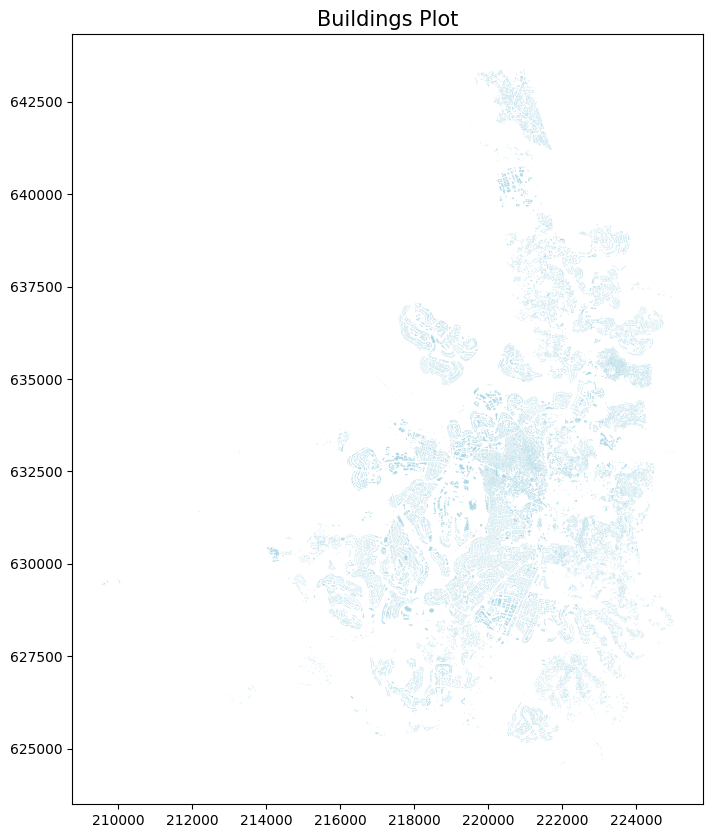

In [6]:
gdb_file = gdb_files[10]
layers = fiona.listlayers(gdb_file)
textures_layer = layers[0]
gdf = gpd.read_file(gdb_file, layer=textures_layer)
print("Layers in the selected GDB:", layers)

m_buildings = gdf[["geometry"]]
m_buildings.head()
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buildings with custom colors and edge color
m_buildings.plot(ax=ax, color='lightblue')

# Add a title and display the plot
plt.title("Buildings Plot", fontsize=15)
plt.show()

In [7]:
# Choose a specific .gdb file (first one in this case)
gdb_file = gdb_files[10]  # Modify if you want to choose a different .gdb
print(gdb_file)
# List the layers in the selected .gdb
layers = fiona.listlayers(gdb_file)
print("Layers in the selected GDB:", layers)

# Choose a specific layer within the .gdb
textures_layer = layers[0]  # Modify if you want to choose a different layer

# Load the specific layer
gdf = gpd.read_file(gdb_file, layer=textures_layer)
m_buildings = gdf[["geometry"]]
m_buildings.head()
limit = momepy.buffered_limit(m_buildings)
tessellation = momepy.morphological_tessellation(m_buildings, clip=limit)
collapsed, _ = momepy.verify_tessellation(tessellation, m_buildings)
buildings = m_buildings.drop(collapsed)
# limit = momepy.buffered_limit(buildings, "adaptive")
# tessellation = momepy.morphological_tessellation(buildings, clip=limit)
tessellation.shape[0] == buildings.shape[0]


/content/drive/My Drive/Michaels_data/all_Layers/מרקמים/קונטור בניינים/commondata/jps_reka.gdb
Layers in the selected GDB: ['buildings']


<ipython-input-7-329e2044908f>:17: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. Index of affected elements: [20538, 20888, 30302, 33013].
  collapsed, _ = momepy.verify_tessellation(tessellation, m_buildings)


True

In [10]:
def find_group_leading_metrics(gdf, classification_column, n_components=2):
    group_leading_metrics = {}

    # Standardize the features
    scaler = StandardScaler()

    # Group by classification
    for group, group_data in gdf.groupby(classification_column):
        print(f"\nFinding leading metrics for group: {group}")

        # Drop the classification and geometry columns
        group_features = group_data.drop(columns=[classification_column, 'geometry'])

        # Standardize the group-specific data
        scaled_features = scaler.fit_transform(group_features)

        # Apply PCA
        pca = PCA(n_components=n_components)
        pca.fit(scaled_features)

        # Get the principal components
        components = pca.components_

        # Create a DataFrame of components with feature names
        leading_metrics = pd.DataFrame(components, columns=group_features.columns)

        # Sort metrics by their absolute contribution to the principal components
        sorted_metrics = leading_metrics.apply(lambda x: x.abs().sort_values(ascending=False).index, axis=1)

        # Store the top metrics for this group
        group_leading_metrics[group] = sorted_metrics.head(2)  # Top 2 metrics per group

        # Print the top 2 metrics
        print(f"Top metrics for group {group}:")
        print(sorted_metrics.head(2))

    return group_leading_metrics

data = {
    'building_height': [10, 12, 8, 15],
    'Convexity': [5, 9, 2, 2],
    'Compactness': [4, 33, 2, 11],
    'floor_aqrea': [33, 100, 200, 2],
    'orientation': [200, 250, 20, 10],
    'building_ERI': [100, 150, 120, 130],
    'building_area': [200, 250, 180, 300],
    'area_classification': ['1', '1', '2', '2'],
    'geometry': [Point(1, 2), Point(2, 3), Point(3, 4), Point(4, 5)]
}

gdf = gpd.GeoDataFrame(data, geometry='geometry')
classification_column = 'area_classification'
leading_metrics_per_group = find_group_leading_metrics(gdf, classification_column, n_components=1)

# Display the results


Finding leading metrics for group: Group1
Top metrics for group Group1:
0    Index(['Convexity', 'Compactness', 'floor_aqre...
dtype: object

Finding leading metrics for group: Group2
Top metrics for group Group2:
0    Index(['building_height', 'Compactness', 'floo...
dtype: object


In [9]:


def find_overall_leading_metrics(gdf, classification_column):
    # Drop the classification and geometry columns for feature selection
    features = gdf.drop(columns=[classification_column, 'geometry'])
    target = gdf[classification_column]

    # Standardize the features (optional, but often helpful)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Train a Random Forest model on the whole data
    model = RandomForestClassifier(random_state=42)
    model.fit(scaled_features, target)

    # Extract and sort feature importances
    feature_importances = pd.Series(model.feature_importances_, index=features.columns)
    feature_importances = feature_importances.sort_values(ascending=False)

    # Print the leading metrics
    print("Overall leading metrics for classification:")
    print(feature_importances.head(10))  # Top 10 most important metrics

    return feature_importances


classification_column = 'area_classification'
top_metrics_per_group = find_overall_leading_metrics(gdf, classification_column)

Overall leading metrics for classification:
Convexity          0.200000
orientation        0.172549
building_height    0.168627
building_ERI       0.129412
building_area      0.117647
Compactness        0.105882
floor_aqrea        0.105882
dtype: float64
